In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ALNY_processed.csv')
df1 = df.reset_index()['Close']

In [ ]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test validate

choose = 3
# 7:3
if choose == 1:
  train_size = int(0.7 * len(df1))
  test_size = int(0.3 * len(df1))

  train_data = df1[:train_size]
  test_data = df1[train_size:train_size+test_size]

# 8:2
elif choose == 2:
  train_size = int(0.8 * len(df1))
  test_size = int(0.2 * len(df1))

  train_data = df1[:train_size]
  test_data = df1[train_size:train_size+test_size]

# 6:4
elif choose == 3:
  train_size = int(0.6 * len(df1))
  test_size = int(0.4 * len(df1))

  train_data = df1[:train_size]
  test_data = df1[train_size:train_size+test_size]

print("Train: ", train_size)
print("Test: ", test_size)

Train:  1096
Test:  730


In [ ]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [ ]:
# 6. Reshape dữ liệu thành dạng input cho phương pháp Gauss-Newton
X_train, y_train = create_dataset(train_data, time_step=100)
X_test, y_test = create_dataset(test_data, time_step=100)

In [ ]:
# 7. Định nghĩa mô hình phi tuyến và các hàm liên quan
def nonlinear_model(params, x):
    a, b, c = params
    return a * x**2 + b * x + c

def target_function(params, x, y):
    return nonlinear_model(params, x) - y

def jacobian(params, x):
    a, b, _ = params
    jac = np.zeros((len(x), len(params)))
    jac[:, 0] = x**2
    jac[:, 1] = x
    jac[:, 2] = 1
    return jac

def gauss_newton(params, x, y, max_iter=100, tol=1e-6):
    for i in range(max_iter):
        f = target_function(params, x, y)
        J = jacobian(params, x)
        delta = np.linalg.lstsq(J, -f, rcond=None)[0]
        params += delta
        if np.linalg.norm(delta) < tol:
            break
    return params


In [ ]:
# 8. Fit mô hình với dữ liệu train
initial_guess = np.array([0.0, 0.0, 0.0], dtype=np.float64)
params = gauss_newton(initial_guess, X_train[:, 99], y_train)


In [ ]:
# 9. Dự báo dữ liệu test, val
y_pred_train = nonlinear_model(params, X_train[:, 99])
y_pred_test = nonlinear_model(params, X_test[:, 99])


In [ ]:
# 10. Chuẩn hóa dữ liệu y_pred, y_pred_val
y_pred_train = scaler.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))


In [ ]:
# Tính toán RMSE
train_rmse = np.sqrt(np.mean((y_pred_train - scaler.inverse_transform(y_train.reshape(-1, 1)))**2))
test_rmse = np.sqrt(np.mean((y_pred_test - scaler.inverse_transform(y_test.reshape(-1, 1)))**2))

# Tính toán MAE
train_mae = np.mean(np.abs(y_pred_train - scaler.inverse_transform(y_train.reshape(-1, 1))))
test_mae = np.mean(np.abs(y_pred_test - scaler.inverse_transform(y_test.reshape(-1, 1))))

# Tính toán MAPE
train_mape = np.mean(np.abs((y_pred_train - scaler.inverse_transform(y_train.reshape(-1, 1))) / scaler.inverse_transform(y_train.reshape(-1, 1)))) * 100
test_mape = np.mean(np.abs((y_pred_test - scaler.inverse_transform(y_test.reshape(-1, 1))) / scaler.inverse_transform(y_test.reshape(-1, 1)))) * 100

print('Training RMSE:', train_rmse)
print('Testing RMSE:', test_rmse)
print('Training MAE:', train_mae)
print('Testing MAE:', test_mae)
print('Training MAPE:', train_mape)
print('Testing MAPE:', test_mape)


Training RMSE: 2.995083421015136
Testing RMSE: 4.503229517751418
Training MAE: 1.9766898112723459
Testing MAE: 2.4712997425292045
Training MAPE: 1.4398692192148081
Testing MAPE: 1.2813548539204866


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def predict_future_days(test_data, nonlinear_model, params, days_to_predict, n_steps=100):
    x_input = test_data[-n_steps:].reshape(1, -1)
    temp_input = list(x_input[0])

    lst_output = []

    for _ in range(days_to_predict):
        if len(temp_input) > n_steps:
            x_input = np.array(temp_input[1:])
            yhat = nonlinear_model(params, x_input[-1])
            temp_input.append(yhat.tolist())
            temp_input = temp_input[1:]
        else:
            x_input = np.array(temp_input)
            yhat = nonlinear_model(params, x_input[-1])
            temp_input.append(yhat.tolist())

        lst_output.append(yhat.tolist())

    return lst_output

days_30 = predict_future_days(test_data, nonlinear_model, params, 30)
days_60 = predict_future_days(test_data, nonlinear_model, params, 60)
days_90 = predict_future_days(test_data, nonlinear_model, params, 90)


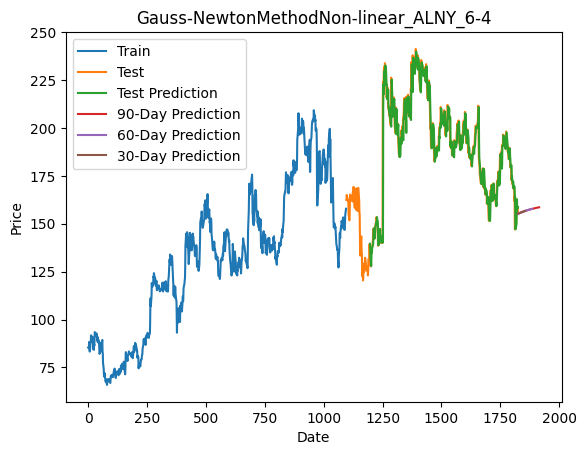

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Giả sử các biến sau đã được định nghĩa: train_size, test_size, scaler, train_data, test_data, y_pred_test, df1, days_90, days_60, days_30

# Plotting section
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

test_data_pred_index = pd.RangeIndex(start=train_size + 101, stop=train_size + 101 + len(y_pred_test), step=1)
plt.plot(test_data_pred_index, y_pred_test, label='Test Prediction')

predict_data_index_90 = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 89, step=1)
plt.plot(predict_data_index_90, scaler.inverse_transform(np.array(days_90).reshape(-1, 1)), label='90-Day Prediction')

predict_data_index_60 = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 59, step=1)
plt.plot(predict_data_index_60, scaler.inverse_transform(np.array(days_60).reshape(-1, 1)), label='60-Day Prediction')

predict_data_index_30 = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 29, step=1)
plt.plot(predict_data_index_30, scaler.inverse_transform(np.array(days_30).reshape(-1, 1)), label='30-Day Prediction')

plt.legend()
plt.title("Gauss-NewtonMethodNon-linear_ALNY_6-4")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()